# BL 1-5: SAXS data correction and reduction



#!/usr/bin/env python3

"""
Created on Fri Apr 21 23:41:02 2023

@author: akmaurya
"""

Global stuff

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
#from axis_plot_prop import axis_plot_prop 
import pyFAI
import shutil
import fabio
from pyFAI.gui.jupyter.calib import Calibration
from typing import List, Dict, Tuple, Optional, Union, Any
import pandas as pd

import os
import fnmatch


import warnings
warnings.filterwarnings('ignore')

# Common functions for the project

In [2]:
# plot setting fucntion

def axis_plot_prop(ax) -> None:
    """
    Set axis properties for plotting.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axis object to set properties for.
    """

    co = [
        [0, 0, 0],
        [1, 0, 0],
        [0.44, 0.00, 0.99],
        [1.00, 0.50, 0.10],
        [0.75, 0.00, 0.75],
        [0.50, 0.50, 0.50],
        [0.50, 0.57, 0.00],
        [0.64, 0.08, 0.18],
        [0.93, 0.00, 0.00]
    ]

    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=co)

    ax.set_facecolor('white')
    ax.spines['top'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.tick_params(axis='both', which='both', direction='in', length=4, width=1)
    ax.minorticks_on()
    ax.set_xlabel('X Label', fontsize=20, fontname='Arial')
    ax.set_ylabel('Y Label', fontsize=20, fontname='Arial')
    ax.tick_params(axis='both', labelsize=20)
    ax.legend(frameon=False)
    #ax.set_box_aspect(1)
    plt.tight_layout()
#2D plot settings function
# import matplotlib.pyplot as plt

def set_pcolor_properties() -> None:
    """
    Sets the best figure properties for pcolormap plot
    """
    plt.rcParams["figure.figsize"] = (6, 6)  # Set the figure size to 8 inches by 6 inches
    plt.rcParams["font.size"] = 20  # Set the font size to 12 points
    plt.rcParams["axes.linewidth"] = 1.5  # Set the linewidth of the axes to 1.5
    #plt.rcParams["axes.grid"] = True  # Show the grid
    #plt.rcParams["grid.alpha"] = 0.5  # Set the transparency of the grid to 0.5
    #plt.rcParams["grid.linewidth"] = 0.5  # Set the linewidth of the grid to 0.5
    plt.rcParams["image.cmap"] = "viridis"  # Set the colormap to viridis
    plt.rcParams["image.interpolation"] = "nearest"  # Set the interpolation to nearest

# create and update folder to save data
def create_update_subfolder(base_folder: str, common_keyword: str) -> str:
    """
    Create or update a subfolder within a base folder.
    
    Parameters
    ----------
    base_folder : str
        Path to the base folder
    common_keyword : str
        Name of the subfolder to create
        
    Returns
    -------
    str
        Path to the created/existing subfolder
    """
    common_folder_path = os.path.join(base_folder, common_keyword)
    
    if os.path.exists(base_folder) and os.path.isdir(common_folder_path):
        print(f"Subfolder '{common_keyword}' already exists within the base folder.")
    else:
        os.makedirs(common_folder_path)
        print(f"Subfolder '{common_keyword}' created within the base folder.")

    return common_folder_path

# Convert pixel by pixel to qx by qy 2D SAXS plot

def convert_saxs_to_q(data: np.ndarray, pixel_size: float, wavelength: float, 
                     detector_distance: float, beam_x: float, beam_y: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert SAXS detector pixel coordinates to q-space coordinates.
    
    Parameters
    ----------
    data : np.ndarray
        2D detector data array
    pixel_size : float
        Size of detector pixels in meters
    wavelength : float
        X-ray wavelength in meters
    detector_distance : float
        Sample-to-detector distance in meters
    beam_x : float
        Beam center x-coordinate in pixels
    beam_y : float
        Beam center y-coordinate in pixels
        
    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        qx and qy arrays in nm^-1
    """
    # Define grid of pixel coordinates (assumes data is square)
    #x_pixels,y_pixels = data.shape
    x_pixels = 981
    y_pixels = 1043
    x_coords = np.arange(x_pixels) - beam_x
    y_coords = np.arange(y_pixels) - beam_y
    xx, yy = np.meshgrid(x_coords, y_coords)

    # Convert to q-space coordinates
    qx = 1e-9*2 * np.pi / wavelength * np.sin(pixel_size * xx / detector_distance)
    qy = 1e-9*2 * np.pi / wavelength * np.sin(pixel_size * yy / detector_distance)

    #print (len(xx))
    
    return qx, qy


    #print (qx)
    
def convert_waxs_to_q(data: np.ndarray, pixel_size: float, wavelength: float, 
                     detector_distance: float, beam_x: float, beam_y: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert WAXS detector pixel coordinates to q-space coordinates.
    
    Parameters
    ----------
    data : np.ndarray
        2D detector data array
    pixel_size : float
        Size of detector pixels in meters
    wavelength : float
        X-ray wavelength in meters
    detector_distance : float
        Sample-to-detector distance in meters
    beam_x : float
        Beam center x-coordinate in pixels
    beam_y : float
        Beam center y-coordinate in pixels
        
    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        qx and qy arrays in nm^-1
    """
    # Define grid of pixel coordinates (assumes data is square)
    #x_pixels,y_pixels = data.shape
    x_pixels = 487
    y_pixels = 195
    x_coords = np.arange(x_pixels) - beam_x
    y_coords = np.arange(y_pixels) - beam_y
    xx, yy = np.meshgrid(x_coords, y_coords)

    # Convert to q-space coordinates
    qx = 1e-9*2 * np.pi / wavelength * np.sin(pixel_size * xx / detector_distance)
    qy = 1e-9*2 * np.pi / wavelength * np.sin(pixel_size * yy / detector_distance)

    print (len(xx))
    
    return qx, qy


def set_plot_style(axs, fonts: int, xlabel: str, ylabel: str):
    """
    Set standardized plot style properties.
    
    Parameters
    ----------
    axs : plt.Axes
        Matplotlib axes object
    fonts : int
        Font size for labels and ticks
    xlabel : str
        X-axis label
    ylabel : str
        Y-axis label
        
    Returns
    -------
    plt.Axes
        Modified axes object
    """
    axs.set_xlabel(xlabel, fontsize=fonts)
    axs.set_ylabel(ylabel, fontsize=fonts)
    axs.tick_params(axis='both', which='major', direction='out', length=4, width=1)
    axs.tick_params(which='minor', width=1, size=2)  # Adjust size as needed
    #axs.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    axs.set_facecolor('white')
    axs.spines['top'].set_linewidth(1)
    axs.spines['right'].set_linewidth(1)
    axs.spines['bottom'].set_linewidth(1)
    axs.spines['left'].set_linewidth(1)
    axs.tick_params(axis='x', labelsize=fonts)
    axs.tick_params(axis='y', labelsize=fonts)

    return axs    #print (qx) 
 


def darken_colors(num_colors: int, darker_factor: float = 0.7) -> np.ndarray:
    """
    Darken a set of colors by reducing the value component in the HSV color space.

    Parameters
    ----------
    num_colors : int
        Number of colors to generate.
    darker_factor : float, default 0.7
        Factor to control the darkness of the colors.

    Returns
    -------
    np.ndarray
        Darkened colors in RGB format.
    """
    colors = plt.cm.jet(np.linspace(0, 1, num_colors))

    # Make the colors darker by reducing the value component
    darker_colors = colors.copy()

    for i in range(num_colors):
        rgb = darker_colors[i, :3]  # Extract the RGB values
        hsv = plt.cm.colors.rgb_to_hsv(rgb)  # Convert RGB to HSV
        hsv[2] *= darker_factor  # Reduce the value component
        darker_colors[i, :3] = plt.cm.colors.hsv_to_rgb(hsv)  # Convert back to RGB

    return darker_colors

# Inputs

# Poni

In [3]:
#folder_path_poni_mask = '/Users/akmaurya/Library/CloudStorage/OneDrive-SLACNationalAcceleratorLaboratory/My Onedrive/Data_01/Methanolysis/Python/Data_Reduction/Convert_and_calibrate'
#folder_path_poni_mask = r'C:\Users\b_tassone\Desktop\Anjani\Python\Convert_and_calibrate'
#folder_path_poni_mask = '/Users/akmaurya/OneDrive - Stanford/Python_library/Acetolysis/May2024/Python/Convert_and_calibrate/Convert_and_calibrate'
base_dir = r'./atT_smaller'
folder_path_poni_mask = os.path.join(base_dir, 'poni')


SAXS_poni_file = "atT_SAXS.poni"
WAXS_poni_file = "atT_WAXS.poni"

# SAXS

In [4]:
poni_file_path = os.path.join(folder_path_poni_mask,SAXS_poni_file)
print(poni_file_path)
ai = pyFAI.load(poni_file_path)

print(ai)

#Define detector parameters for 2D q conversion
pixel_size = ai.get_pixel1() # in meters 
wavelength = ai.get_wavelength() #1.54e-10  # in meters
detector_distance = ai.get_dist()  # in meters

# Vivek: Removed the hardcoded values
beam_y = ai.poni1/pixel_size
beam_x = ai.poni2/pixel_size
# beam_x=491.215
# beam_y=626.705 # beam center x-coordinate in pixels


./atT_smaller/poni/atT_SAXS.poni
Detector Pilatus 1M	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.033202e-10 m
SampleDetDist= 2.909697e+00 m	PONI= 1.077932e-01, 8.448894e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 2909.697 mm	Center: x=491.215, y=626.705 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.033Å


#mask for SAXS

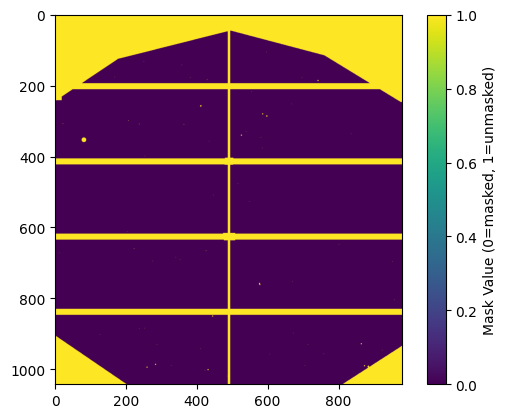

In [5]:
# Load the poni file and extract relevant parameters
saxs_mask = os.path.join(folder_path_poni_mask, "RT_SAXS_mask_03.edf")

#mask = "/Users/yuewu/Desktop/8091E/BL15_1M_gcarbon_mask_3.edf"
saxs_mask = fabio.open(saxs_mask).data
im = plt.imshow(saxs_mask)# display the mask
plt.colorbar(im, label='Mask Value (0=masked, 1=unmasked)')


# WAXS

In [6]:

# Load the poni file and extract relevant parameters
poni_file_path = os.path.join(folder_path_poni_mask, WAXS_poni_file)
ai_w = pyFAI.load(poni_file_path)

print(ai_w)



#Define detector parameters for 2D q conversion
pixel_size = ai_w.get_pixel1() # in meters 
wavelength = ai_w.get_wavelength() #1.54e-10  # in meters
detector_distance = ai_w.get_dist()  # in meters
beam_x= 668.647
beam_y= 105.765 # beam center x-coordinate in pixels


Detector Pilatus 100k	 PixelSize= 172µm, 172µm	 BottomRight (3)
Wavelength= 1.033202e-10 m
SampleDetDist= 1.576850e-01 m	PONI= 1.846850e-02, 1.468911e-02 m	rot1=-0.566608  rot2=-0.001481  rot3=0.000000 rad
DirectBeamDist= 186.891 mm	Center: x=668.647, y=105.765 pix	Tilt= 32.464° tiltPlanRotation= -0.158° 𝛌= 1.033Å


#mask for WAXS

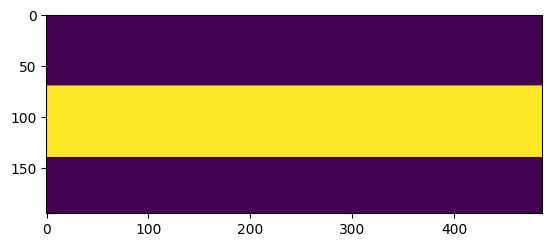

In [7]:
# Load the poni file and extract relevant parameters
waxs_mask = os.path.join(folder_path_poni_mask, "RT_WAXS_mask.edf")

#mask = "/Users/yuewu/Desktop/8091E/BL15_1M_gcarbon_mask_3.edf"
waxs_mask = fabio.open(waxs_mask).data
plt.imshow(waxs_mask)# display the mask

# offsets and air

Vivek: Should these be moved to the config file?

In [8]:
# get this from Empty Beam: shutter closed 

# i0_offset = 0.285816667
# bstop_offset = 0.477621111

# # average from without sample in the beam: named as "Air" is the satandard 

# i0_air = 21.279793333333334
# bstop_air = 18.650270000000003


# 

# function to calculate mu and thickness

In [9]:
import periodictable as pt
import xraydb
import numpy as np

def calculate_sld_mu_thickness(energy_keV: float, density: float, transmission: float) -> Dict[str, float]:
    """
    Calculate scattering length density (SLD), absorption coefficient (mu), and thickness
    from transmission data for polyethylene (PE).
    
    Parameters
    ----------
    energy_keV : float
        X-ray energy in keV
    density : float
        Material density in g/cm³
    transmission : float
        Transmission factor (must be in range (0, 10])
        
    Returns
    -------
    Dict[str, float]
        Dictionary containing:
        - 'mu': absorption coefficient in 1/m
        - 'sld': scattering length density
        - 'thickness_m': sample thickness in meters
        
    Raises
    ------
    ValueError
        If transmission is outside valid range or calculation fails
    """
    try:
        # Define PE composition correctly
        material = pt.formula("C2H4")  # Assuming PE as (C2H4)n

        # Calculate scattering length density (SLD) and mu using periodictable
        sld, mu_pt = pt.xray_sld(material, energy=energy_keV, density=density)

        # Use xraydb for a more reliable absorption coefficient (mu) calculation
        mu_xraydb = xraydb.material_mu("C2H4", energy=energy_keV * 1000, density=density) * 100  # Convert to 1/m

        # Calculate thickness using transmission: T = exp(-mu * t) → t = -ln(T) / mu
        if transmission <= 0 or transmission > 10:
            raise ValueError("Transmission must be in the range (0, 1].")
        
        thickness = -np.log(transmission) / mu_xraydb  # Thickness in meters

        return {"mu": mu_xraydb, "sld": sld, "thickness_m": thickness}

    except Exception as e:
        raise ValueError(f"Error in calculating SLD, mu, and thickness for PE: {e}")

# Example usage
energy_keV = 12      # Energy in keV
density_PE = 0.92       # Density in g/cm^3
#transmission = 0.92   # Transmission (must be between 0 and 1)

#result = calculate_sld_mu_thickness(energy_keV, density_PE, transmission)
#print(result)

# Set the directory containing the raw and pdi files and list the keyword

In [10]:
import os
import fnmatch

def find_folders_with_keyword(folder_path: str, keyword: str, skip_folders: Optional[List[str]] = None) -> List[str]:
    """
    Find folders matching a keyword pattern, optionally skipping specified folders.
    
    Parameters
    ----------
    folder_path : str
        Path to search for folders
    keyword : str
        Pattern to match folder names (supports wildcards)
    skip_folders : Optional[List[str]], default None
        List of folder names to skip
        
    Returns
    -------
    List[str]
        List of folder names matching the keyword pattern
    """
    folder_names = []
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path) and fnmatch.fnmatch(item, keyword):
            if skip_folders is None or item not in skip_folders:
                folder_names.append(item)

    return folder_names

def get_keywords(raw_dir: str, common_keyword: str, keyword: str) -> Tuple[List[str], str, str, str]:
    """
    Get keywords and create folder structure for SAXS/WAXS data processing.
    
    Parameters
    ----------
    raw_dir : str
        Base directory containing raw data
    common_keyword : str
        Common folder name pattern
    keyword : str
        Specific keyword pattern to search for
        
    Returns
    -------
    Tuple[List[str], str, str, str]
        - List of sorted folder names (keywords)
        - SAXS folder path
        - WAXS folder path  
        - Data folder path
    """
    data_folder = os.path.join(raw_dir, common_keyword)
    base_SAXS_folder = "OneD_integrated_SAXS_01/Reduction"
    base_SAXS_folder = os.path.join(raw_dir, base_SAXS_folder)
    base_WAXS_folder = "OneD_1dd_WAXS_01/Reduction"
    base_WAXS_folder = os.path.join(raw_dir, base_WAXS_folder)

    SAXS_folder_name = create_update_subfolder(base_SAXS_folder, common_keyword)
    WAXS_folder_name = create_update_subfolder(base_WAXS_folder, common_keyword)

    folder_names_with_keyword = find_folders_with_keyword(data_folder, keyword)

    ctr_values = [int(name.split('_ctr')[-1]) for name in folder_names_with_keyword]
    sorted_folder_names = [x for _, x in sorted(zip(ctr_values, folder_names_with_keyword))]

    keywords = sorted_folder_names
    return keywords, SAXS_folder_name, WAXS_folder_name,data_folder



# read parameters function

In [11]:
def process_and_store_selected_parameters_columns(data_folder: str, keywords: List[str]) -> Dict[str, pd.DataFrame]:
    """
    Process CSV parameter files and extract selected columns for each keyword.
    
    Parameters
    ----------
    data_folder : str
        Path to folder containing CSV parameter files
    keywords : List[str]
        List of keyword patterns to search for files
        
    Returns
    -------
    Dict[str, pd.DataFrame]
        Dictionary mapping file names to DataFrames with selected columns
    """
    # Create an empty dictionary to store the selected columns for each file
    selected_columns_dict = {}

    for keyword in keywords:
        # Create a list of file paths that match the file types and current keyword
        #raw_file_pattern = f'*{keyword}/SAXS/*.raw'
        pdi_file_pattern = f'*{keyword}/*_scan1.csv'
        #raw_file_paths = sorted(glob.glob(os.path.join(raw_dir, raw_file_pattern)))
        pdi_file_paths = sorted(glob.glob(os.path.join(data_folder, pdi_file_pattern)))

        for pdi_file_path in pdi_file_paths:
            try:
                # Read the CSV file
                df = pd.read_csv(pdi_file_path)
                file_name = os.path.splitext(os.path.basename(pdi_file_path))[0]
                #print(f"Reading file: {file_name}")

                # Extract columns seconds, io, bstop, temp, ctemp, timer
                selected_columns = df.iloc[:, [2, 3, 6, 10, 29, 30]]

                # Store the selected columns in the dictionary with the file name as the key
                selected_columns_dict[file_name] = selected_columns

            except FileNotFoundError:
                print(f"File not found: {pdi_file_path}")
            except Exception as e:
                print(f"An error occurred: {e}")

    return selected_columns_dict

# Call the function and pass the raw_dir and keywords as arguments
#raw_dir = 'path_to_your_raw_files_directory'
#keywords = ['keyword1', 'keyword2', 'keyword3']  # Replace with your actual keywords
#
# To load the result_dict back from the file, you can use the following code:

#print(result_dict)

In [12]:
import pandas as pd
import os
import glob

def read_parameters(data_folder: str, keyword: str, result_dict: Dict[str, pd.DataFrame]) -> Dict[str, List[float]]:
    """
    Reads and processes parameter data from CSV files matching a pattern, calculates averages, 
    and returns a dictionary with results.

    Parameters
    ----------
    data_folder : str
        Path to the folder containing CSV files.
    keyword : str
        Keyword to filter files.
    result_dict : Dict[str, pd.DataFrame]
        Dictionary containing preloaded DataFrames indexed by filenames.

    Returns
    -------
    Dict[str, List[float]]
        Dictionary containing averages and filenames with keys:
        - 'bstop_dx_avg': List of individual beamstop averages
        - 'ctemp_dx_avg': List of individual temperature averages  
        - 'timer_dx_avg': List of individual timer averages
        - 'i0_dx_avg': List of individual I0 averages
        - 'bstop_avg_all': List with overall beamstop average
        - 'ctemp_avg_all': List with overall temperature average
        - 'timer_avg_all': List with overall timer average
        - 'i0_avg_all': List with overall I0 average
        - 'avg_file_name': List of processed filenames
    """
    # Initialize lists to store results
    bstop_dx_avg, ctemp_dx_avg, timer_dx_avg, i0_dx_avg = [], [], [], []
    bstop_avg_all, ctemp_avg_all, timer_avg_all, i0_avg_all = [], [], [], []
    avg_file_name = []

    # File matching pattern
    pdi_file_pattern = f'*{keyword}/*_scan1.csv'
    pdi_file_paths = sorted(glob.glob(os.path.join(data_folder, pdi_file_pattern)))

    for pdi_file_path in pdi_file_paths:
        file_name = os.path.splitext(os.path.basename(pdi_file_path))[0]
        selected_columns = result_dict.get(file_name)

        if selected_columns is not None:
            try:
                # Access columns safely
                i0 = pd.to_numeric(selected_columns.iloc[:, 1], errors='coerce')
                bstop = pd.to_numeric(selected_columns.iloc[:, 2], errors='coerce')
                ctemp = pd.to_numeric(selected_columns.iloc[:, 4], errors='coerce')
                timer = pd.to_numeric(selected_columns.iloc[:, 5], errors='coerce')

                # Calculate averages
                i0_dx_avg.append(i0.mean(skipna=True))
                bstop_dx_avg.append(bstop.mean(skipna=True))
                ctemp_dx_avg.append(ctemp.mean(skipna=True))
                timer_dx_avg.append(timer.mean(skipna=True))

                # Add filename to results
                avg_file_name.append(file_name)
            except (ValueError, IndexError) as e:
                print(f"Error processing file '{file_name}': {str(e)}")
        else:
            print(f"File '{file_name}' not found in result_dict.")

    # Compute overall averages if data exists
    if i0_dx_avg:
        i0_avg_all.append(sum(i0_dx_avg) / len(i0_dx_avg))
        bstop_avg_all.append(sum(bstop_dx_avg) / len(bstop_dx_avg))
        ctemp_avg_all.append(sum(ctemp_dx_avg) / len(ctemp_dx_avg))
        timer_avg_all.append(sum(timer_dx_avg) / len(timer_dx_avg))

    return {
        'bstop_dx_avg': bstop_dx_avg,
        'ctemp_dx_avg': ctemp_dx_avg,
        'timer_dx_avg': timer_dx_avg,
        'i0_dx_avg': i0_dx_avg,
        'bstop_avg_all': bstop_avg_all,
        'ctemp_avg_all': ctemp_avg_all,
        'timer_avg_all': timer_avg_all,
        'i0_avg_all': i0_avg_all,
        'avg_file_name': avg_file_name,
    }

# SAXS Data reduction function

In [13]:
from isort import file
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import re
#import warnings

# Filter warnings containing the substring "pyFAI.io"
#warnings.filterwarnings("ignore", message="pyFAI.io")

# Map a parameter (e.g., q) to a colormap


def custom_sort(file_name: str) -> Tuple[int, int]:
    """
    Custom sorting function for SAXS files based on keywords and counter values.
    
    Parameters
    ----------
    file_name : str
        File name to sort
        
    Returns
    -------
    Tuple[int, int]
        Tuple of (keyword_index, counter_value) for sorting
    """
    keywords = ['ctr', 'HoldT', 'Cooling','RampT', '']
    keyword_found = next((kw for kw in keywords if kw in file_name), '')
    ctr_value = int(file_name.split('ctr')[-1].split('_')[0]) if 'ctr' in file_name else 0
    return (keywords.index(keyword_found), ctr_value)



def process_SAXS_data(SAXS_folder_name: str, keywords: List[str], data_folder: str, 
                     ai, mask: np.ndarray, 
                     i0_offset: float, bstop_offset: float, i0_air: float, bstop_air: float) -> None:
    """
    Process SAXS raw data files through normalization, correction, and 1D integration.
    
    Parameters
    ----------
    SAXS_folder_name : str
        Output folder path for processed SAXS data
    keywords : List[str]
        List of keyword patterns to process
    data_folder : str
        Path to folder containing raw data files
    ai: PyFAI integrator object with detector geometry
    mask : np.ndarray
        Detector mask array
    i0_offset : float
        I0 detector dark current offset
    bstop_offset : float
        Beamstop detector dark current offset  
    i0_air : float
        I0 reading for air/empty measurement
    bstop_air : float
        Beamstop reading for air/empty measurement
    """
    # print the processting saxs data
    print("Processing SAXS data...")

    save_SAXS_norm_files = os.path.join(SAXS_folder_name.replace("Reduction", ""), "Correction/Normlised")
    if not os.path.exists(save_SAXS_norm_files):
        os.makedirs(save_SAXS_norm_files)
    result_dict = process_and_store_selected_parameters_columns(data_folder, keywords)
    #warnings.filterwarnings('ignore')
    bstop = []
    ctemp = []
    timer = []
    i0 = []
    filename_p = []
    file_name_norm = []



    # Create a figure with 1 row and 2 columns
    fig, axs = plt.subplots(figsize=(8,8))
    c=0
    
    num_colors = len(keywords)  # Calculate the number of colors based on the maximum m_key
    
    #num_colors = 57
    
    print(num_colors)
    darker_colors = darken_colors(num_colors, darker_factor=0.7)
    for keyword in keywords:
        # Create a list of file paths that match the file types and current keyword
        raw_file_pattern = f'{keyword}/SAXS/*.raw'
        #raw_file_paths = sorted(glob.glob(os.path.join(data_folder, raw_file_pattern)))
        raw_file_paths = sorted(glob.glob(os.path.join(data_folder, raw_file_pattern)), key=custom_sort)
        #print(raw_file_paths)
        #print(keyword)



        # read parameters
        # Call the function
        averages_dict = read_parameters(data_folder, keyword, result_dict)

        # Access the averages from the returned dictionary
        bstop_avg_all = averages_dict['bstop_avg_all']
        ctemp_avg_all = averages_dict['ctemp_avg_all']
        timer_avg_all = averages_dict['timer_avg_all']
        i0_avg_all = averages_dict['i0_avg_all']
        avg_file_name = averages_dict['avg_file_name']


        #print(avg_file_name, raw_file_pattern, bstop_avg_all, ctemp_avg_all, timer_avg_all, i0_avg_all)

        bstop.append(bstop_avg_all[0])
        ctemp.append(ctemp_avg_all[0])
        timer.append(timer_avg_all[0])
        i0.append(i0_avg_all[0])
        filename_p.append(avg_file_name[0])  

        #print(i0_offset, bstop_offset)

        i0_avg_all[0] = i0_avg_all[0] - i0_offset
        bstop_avg_all[0] = bstop_avg_all[0] - bstop_offset

        i0_air = i0_air - i0_offset
        bstop_air = bstop_air - bstop_offset

        trans_factor = (bstop_avg_all[0])#/i0_avg_all[0])/(bstop_air/i0_air)
        
        trans_factor_t = (bstop_avg_all[0])#/i0_avg_all[0]
        #print(trans_factor)
        normfactor = trans_factor*i0_avg_all[0]

        result = calculate_sld_mu_thickness(energy_keV, density_PE, trans_factor_t)
        thickness = result['thickness_m']
        #thickness = 0.0001

        #normfactor = trans_factor #* thickness
        normfactor = float(normfactor)
        #print the transfactor, thicknes and normfactor in good format
        print(f"i0:{i0_avg_all[0]}, bstop: {bstop_avg_all[0]}, transmission factor: {trans_factor_t}, thickness: {thickness}, normfactor: {normfactor}")

        #normfactor = 1.0
        #print(normfactor)

        # Initialize the accumulators for the averaged image and pdi data
        avg_image = np.zeros((1043, 981))

        for i, raw_file_path in enumerate(raw_file_paths):
            # Read the raw file
            data = np.fromfile(raw_file_path, dtype=np.int32).reshape(1043, 981)
            avg_image += data

        avg_image /= len(raw_file_paths)

        # Assuming raw_file_paths[-1] contains the file path
        file_name, file_extension = os.path.splitext(os.path.basename(raw_file_paths[-1]))
        file_name = file_name.split('_scan')[0]
        file_name = file_name.split('sone_')[1]

        # Remove the last 10 characters from the file name and the ".raw" extension
        #file_name = file_name[5:-11]
        file_name=f"{file_name}_all_SAXS.dat"
        file_name_norm.append(file_name)

        q, I, error_avg = ai.integrate1d(avg_image, 1000, error_model='poisson', mask=mask, normalization_factor=normfactor, filename=os.path.join(SAXS_folder_name, file_name))
        
        I_norm = I
        I_norm_sigma = error_avg
        
        axs.loglog(q, I, label=f"{file_name}", color=darker_colors[c])
        axs.set_xlabel("q (nm$^{-1}$)")
        axs.set_ylabel("Intensity (a.u.)")
        axs.set_xlim([0.05, 3])
        set_plot_style(axs,20, 'q (nm$^{-1}$)', 'Intensity (a.u.)')
        #axs.legend(fontsize=12)




        # Create a DataFrame for subtracted data
        data = {"q_nm^-1": q, "I_avg_nomrlised": I_norm, "I_norm_sigma": I_norm_sigma}
        df = pd.DataFrame(data)

        # Saving the normalized data to a file
        # remove .dat extension
        file_name = file_name[:-4]

        # remove a string from middle of the file name from _10s to _d and attached first and last part




        dat_filename = f"{save_SAXS_norm_files}/{file_name}_Norm.dat"

        inst_parameters = f'Timer: {timer_avg_all[0]}, bstop: {bstop_avg_all[0]}, ctemp: {ctemp_avg_all[0]}, I0: {i0_avg_all[0]}'
        headers = [
            f"filename: {file_name}",
            f"background : {''}",
            f'Empty : {""}',
            f"{inst_parameters}", 
            'fit_data',
            "q_nm^-1 ------ I_avg_nomrlised ------ I_norm_sigma"]
        commented_headers = ['# ' + header for header in headers]

        with open(dat_filename, 'w') as dat_file:
            dat_file.write('\n'.join(commented_headers) + '\n')
            df.to_csv(dat_file, sep='\t', index=False, header=False)


        plt.tight_layout()
        
        c=c+1
        
    plt.show()

    # Initialize the result list with the first value as 0
    duration = [0]

    # Extracting the minimum timestamp from all the timer values
    min_timer = min(timer)
    #print(timer)

    # Subtract the minimum timestamp from each timer value and append to the result list
    for i in range(1, len(timer)):
        duration_avg = (timer[i] - min_timer) / 3600
        duration.append(duration_avg)
    
    # save the filename, duration, bstop, ctemp, i0 values in a xlsx file
   
    df = pd.DataFrame(list(zip(file_name_norm, timer, bstop, ctemp, i0)), columns =['Filename', 'Timer', 'Bstop', 'Ctemp', 'I0'])
    df.to_excel(os.path.join(SAXS_folder_name, 'SAXS_parameters.xlsx'), index=False)




# Create a figure and subplots
    fig, (axs1,axs2) = plt.subplots(1,2, figsize=(10, 4))

    # Plot data on the first subplot
    axs1.plot(duration, bstop, 'o', color='b', label='bstop')
    axs1.plot(duration, i0, 'o', color='r', label='I0')
    #axs1.grid(True)
    axs1.legend()
    axs1.set_xlabel('Duration [hr]')
    axs1.set_ylabel('Bstop and I0')
    set_plot_style(axs1,20, 'Duration', 'Bstop, I0')
    

    # Plot data on the second subplot
    axs2.plot(duration, ctemp, 'o', color='r', label='ctemp')
    #axs2.grid(True)
    axs2.legend()
    axs2.set_xlabel('Duration')
    axs2.set_ylabel('Ctemp')
    set_plot_style(axs2,20, 'Duration [hr]', 'Ctemp [C]')

    # Show the plots
    plt.tight_layout()
    plt.show()

'''
#raw_dir_aceto = '/Users/akmaurya/OneDrive - Stanford/Data_01/Acetolysis/May2024/'
#raw_dir_meth = 'C:/Users/akmaurya/OneDrive - Stanford/Data_01/Methanolysis/May2024/'

raw_dir = r'X:\bl1-5\Anjani\Autoxidation\Jan2025\atT'


# Run1
common_keyword = ""
keyword = "Run5*"

keywords, SAXS_folder_name, WAXS_folder_name,data_folder = get_keywords(raw_dir, common_keyword, keyword)
"""
print("Keywords:")
for kw in keywords:
    print(f"    '{kw}',")
"""

#process_SAXS_data(SAXS_folder_name, keywords, data_folder, ai)
#process_WAXS_data(WAXS_folder_name, keywords, data_folder, ai_w)
'''


'\n#raw_dir_aceto = \'/Users/akmaurya/OneDrive - Stanford/Data_01/Acetolysis/May2024/\'\n#raw_dir_meth = \'C:/Users/akmaurya/OneDrive - Stanford/Data_01/Methanolysis/May2024/\'\n\nraw_dir = r\'X:\x08l1-5\\Anjani\\Autoxidation\\Jan2025\x07tT\'\n\n\n# Run1\ncommon_keyword = ""\nkeyword = "Run5*"\n\nkeywords, SAXS_folder_name, WAXS_folder_name,data_folder = get_keywords(raw_dir, common_keyword, keyword)\n"""\nprint("Keywords:")\nfor kw in keywords:\n    print(f"    \'{kw}\',")\n"""\n\n#process_SAXS_data(SAXS_folder_name, keywords, data_folder, ai)\n#process_WAXS_data(WAXS_folder_name, keywords, data_folder, ai_w)\n'

# WAXS Data reduction function

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import re

import warnings

# Filter warnings containing the substring "pyFAI.io"
warnings.filterwarnings("ignore", message="pyFAI.io")

# Your plotting code here...
def custom_sort(file_name: str) -> Tuple[int, int]:
    """
    Custom sorting function for WAXS files based on keywords and counter values.
    
    Parameters
    ----------
    file_name : str
        File name to sort
        
    Returns  
    -------
    Tuple[int, int]
        Tuple of (keyword_index, counter_value) for sorting
    """
    keywords = ['ctr', 'RampT', 'HoldT', 'Cooling', '']
    keyword_found = next((kw for kw in keywords if kw in file_name), '')
    ctr_value = int(file_name.split('ctr')[-1].split('_')[0]) if 'ctr' in file_name else 0
    return (keywords.index(keyword_found), ctr_value)

def process_WAXS_data(WAXS_folder_name: str, keywords: List[str], data_folder: str,
                     ai_w, mask: Optional[np.ndarray], 
                     i0_offset: float, bstop_offset: float, i0_air: float, bstop_air: float) -> None:
    """
    Process WAXS raw data files through normalization, correction, and 1D integration.
    
    Parameters
    ----------
    WAXS_folder_name : str
        Output folder path for processed WAXS data
    keywords : List[str]
        List of keyword patterns to process
    data_folder : str
        Path to folder containing raw data files
    ai_w : pyFAI
        PyFAI integrator object with detector geometry for WAXS
    mask : Optional[np.ndarray]
        Detector mask array, can be None
    i0_offset : float
        I0 detector dark current offset
    bstop_offset : float
        Beamstop detector dark current offset
    i0_air : float
        I0 reading for air/empty measurement
    bstop_air : float
        Beamstop reading for air/empty measurement
    """
    # print the processting waxs data
    print("Processing WAXS data...")
    save_SAXS_norm_files = os.path.join(WAXS_folder_name.replace("Reduction", ""), "Correction/Normlised")
    if not os.path.exists(save_SAXS_norm_files):
        os.makedirs(save_SAXS_norm_files)

    result_dict = process_and_store_selected_parameters_columns(data_folder, keywords)
    #warnings.filterwarnings('ignore')
            # Create a figure with 1 row and 2 columns
    fig, axs = plt.subplots(figsize=(12,12))
    
    bstop = []
    ctemp = []
    timer = []
    i0 = []
    filename_p = []
    file_name_norm = []

    c=0 
    
    num_colors = len(keywords)
    
    darker_colors = darken_colors(num_colors, darker_factor=0.7)

    for keyword in keywords:
        # Create a list of file paths that match the file types and current keyword
        raw_file_pattern = f'{keyword}/WAXS/*.raw'
        #raw_file_paths = sorted(glob.glob(os.path.join(data_folder, raw_file_pattern)))
        raw_file_paths = sorted(glob.glob(os.path.join(data_folder, raw_file_pattern)), key=custom_sort)


# Call the function

        averages_dict = read_parameters(data_folder, keyword, result_dict)

        # Access the averages from the returned dictionary
        bstop_avg_all = averages_dict['bstop_avg_all']
        ctemp_avg_all = averages_dict['ctemp_avg_all']
        timer_avg_all = averages_dict['timer_avg_all']
        i0_avg_all = averages_dict['i0_avg_all']
        avg_file_name = averages_dict['avg_file_name']

        

        #print(avg_file_name, raw_file_pattern, bstop_avg_all, ctemp_avg_all, timer_avg_all, i0_avg_all)

        bstop.append(bstop_avg_all[0])
        ctemp.append(ctemp_avg_all[0])
        timer.append(timer_avg_all[0])
        i0.append(i0_avg_all[0])
        filename_p.append(avg_file_name[0]) 

        i0_avg_all[0] = i0_avg_all[0] - i0_offset
        bstop_avg_all[0] = bstop_avg_all[0] - bstop_offset

        i0_air = i0_air - i0_offset
        bstop_air = bstop_air - bstop_offset

        trans_factor = (bstop_avg_all[0])#/i0_avg_all[0])/(bstop_air/i0_air)
        trans_factor_t = (bstop_avg_all[0])/i0_avg_all[0]
        #print(trans_factor)
        trans_factor = trans_factor*i0_avg_all[0]

        result = calculate_sld_mu_thickness(energy_keV, density_PE, trans_factor_t)
        thickness = result['thickness_m']

        normfactor = trans_factor #* thickness
        normfactor = float(normfactor)
        #print the transfactor, thicknes and normfactor in good format
        print(f"i0:{i0_avg_all[0]}, bstop: {bstop_avg_all[0]}, transmission factor: {trans_factor_t}, thickness: {thickness}, normfactor: {normfactor}")

        normfactor = float(normfactor)
        #normfactor = 1.0
        #print(normfactor)


        # Initialize the accumulators for the averaged image and pdi data
        avg_image = np.zeros((195, 487))

        for i, raw_file_path in enumerate(raw_file_paths):
            # Read the raw file
            data = np.fromfile(raw_file_path, dtype=np.int32).reshape(195, 487)
            avg_image += data

            file_name = os.path.splitext(os.path.basename(raw_file_path))[0]

        avg_image /= len(raw_file_paths)

        # Assuming raw_file_paths[-1] contains the file path
        file_name, file_extension = os.path.splitext(os.path.basename(raw_file_paths[-1]))

        # Remove the last 10 characters from the file name and the ".raw" extension
        # split the file name _scan and remove the last part of the file name
        file_name = file_name.split('_scan')[0]
        file_name=f"{file_name}_all_WAXS.dat"
        file_name=file_name.split('b_tassone_')[1]
        file_name_norm.append(file_name)



        q, I, error_avg = ai_w.integrate1d(avg_image, 1000,error_model='poisson', mask=mask,normalization_factor=normfactor,filename=os.path.join(WAXS_folder_name, file_name))
   
        I_norm = I
        I_norm_sigma = error_avg

        axs.plot(q, I, '-', label=f"{file_name}",color=darker_colors[c])
        axs.set_xlabel("q (nm$^{-1}$)")
        axs.set_ylabel("Intensity (a.u.)")
        set_plot_style(axs,20, 'q (nm$^{-1}$)', 'Intensity (a.u.)')
        #axs.set_xlim([0.05, 3])
        #axs.legend(fontsize=12)

        # Create a DataFrame for subtracted data
        data = {"q_nm^-1": q, "I_avg_nomrlised": I_norm, "I_norm_sigma": I_norm_sigma}
        df = pd.DataFrame(data)

        # Saving the normalized data to a file
        # remove .dat extension
        file_name = file_name[:-4]
        dat_filename = f"{save_SAXS_norm_files}/{file_name}_Norm.dat"

        inst_parameters = f'Timer: {timer_avg_all[0]}, bstop: {bstop_avg_all[0]}, ctemp: {ctemp_avg_all[0]}, I0: {i0_avg_all[0]}'
        headers = [
            f"filename: {file_name}",
            f"background : {''}",
            f'Empty : {""}',
            f"{inst_parameters}", 
            'fit_data',
            "q_nm^-1 ------ I_avg_nomrlised ------ I_norm_sigma"]
        commented_headers = ['# ' + header for header in headers]

        with open(dat_filename, 'w') as dat_file:
            dat_file.write('\n'.join(commented_headers) + '\n')
            df.to_csv(dat_file, sep='\t', index=False, header=False)



        c = c+1
        plt.tight_layout()
        
        
    plt.show()


    # Initialize the result list with the first value as 0
    duration = [0]

    # Extracting the minimum timestamp from all the timer values
    min_timer = min(timer)
    #print(timer)

    # Subtract the minimum timestamp from each timer value and append to the result list
    for i in range(1, len(timer)):
        duration_avg = (timer[i] - min_timer) / 3600
        duration.append(duration_avg)
    # save the filename, duration, bstop, ctemp, i0 values in a xlsx file
   
    df = pd.DataFrame(list(zip(file_name_norm, timer, bstop, ctemp, i0)), columns =['Filename', 'Timer', 'Bstop', 'Ctemp', 'I0'])
    df.to_excel(os.path.join(WAXS_folder_name, 'WAXS_parameters.xlsx'), index=False)



# Create a figure and subplots
    fig, (axs1,axs2) = plt.subplots(1,2, figsize=(10, 4))

    # Plot data on the first subplot
    axs1.plot(duration, bstop, 'o', color='b', label='bstop')
    axs1.plot(duration, i0, 'o', color='r', label='I0')
    #axs1.grid(True)
    axs1.legend()
    axs1.set_xlabel('Duration [hr]')
    axs1.set_ylabel('Bstop and I0')
    set_plot_style(axs1,20, 'Duration', 'Bstop, I0')
    

    # Plot data on the second subplot
    axs2.plot(duration, ctemp, 'o', color='r', label='ctemp')
    #axs2.grid(True)
    axs2.legend()
    axs2.set_xlabel('Duration')
    axs2.set_ylabel('Ctemp')
    set_plot_style(axs2,20, 'Duration [hr]', 'Ctemp [C]')

    # Show the plots
    plt.tight_layout()
    plt.show()


# Ploting function

# Data Reduction

## Autoxidation at T

Subfolder '' already exists within the base folder.
Subfolder '' already exists within the base folder.
Processing SAXS data...
1
i0:21.29209, bstop: 5.80243, transmission factor: 5.80243, thickness: -0.014979151727746935, normfactor: 123.54586177870002


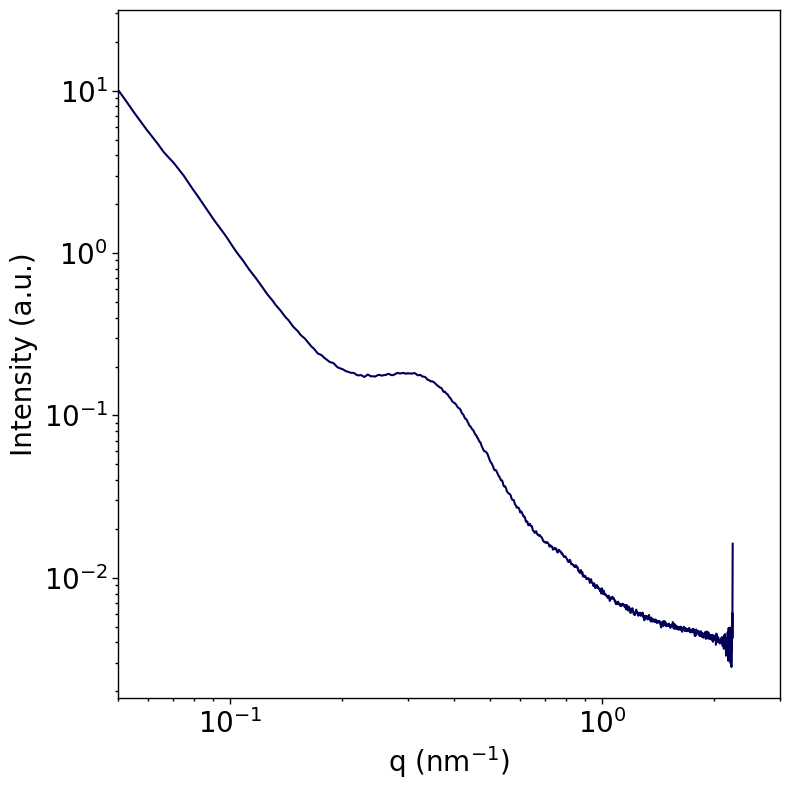

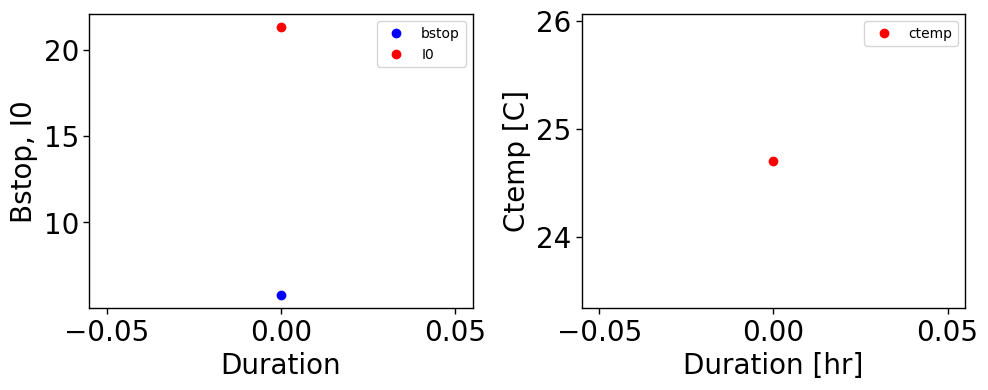

Processing WAXS data...
i0:21.29209, bstop: 5.80243, transmission factor: 0.27251575585111654, thickness: 0.011075490943551404, normfactor: 123.54586177870002


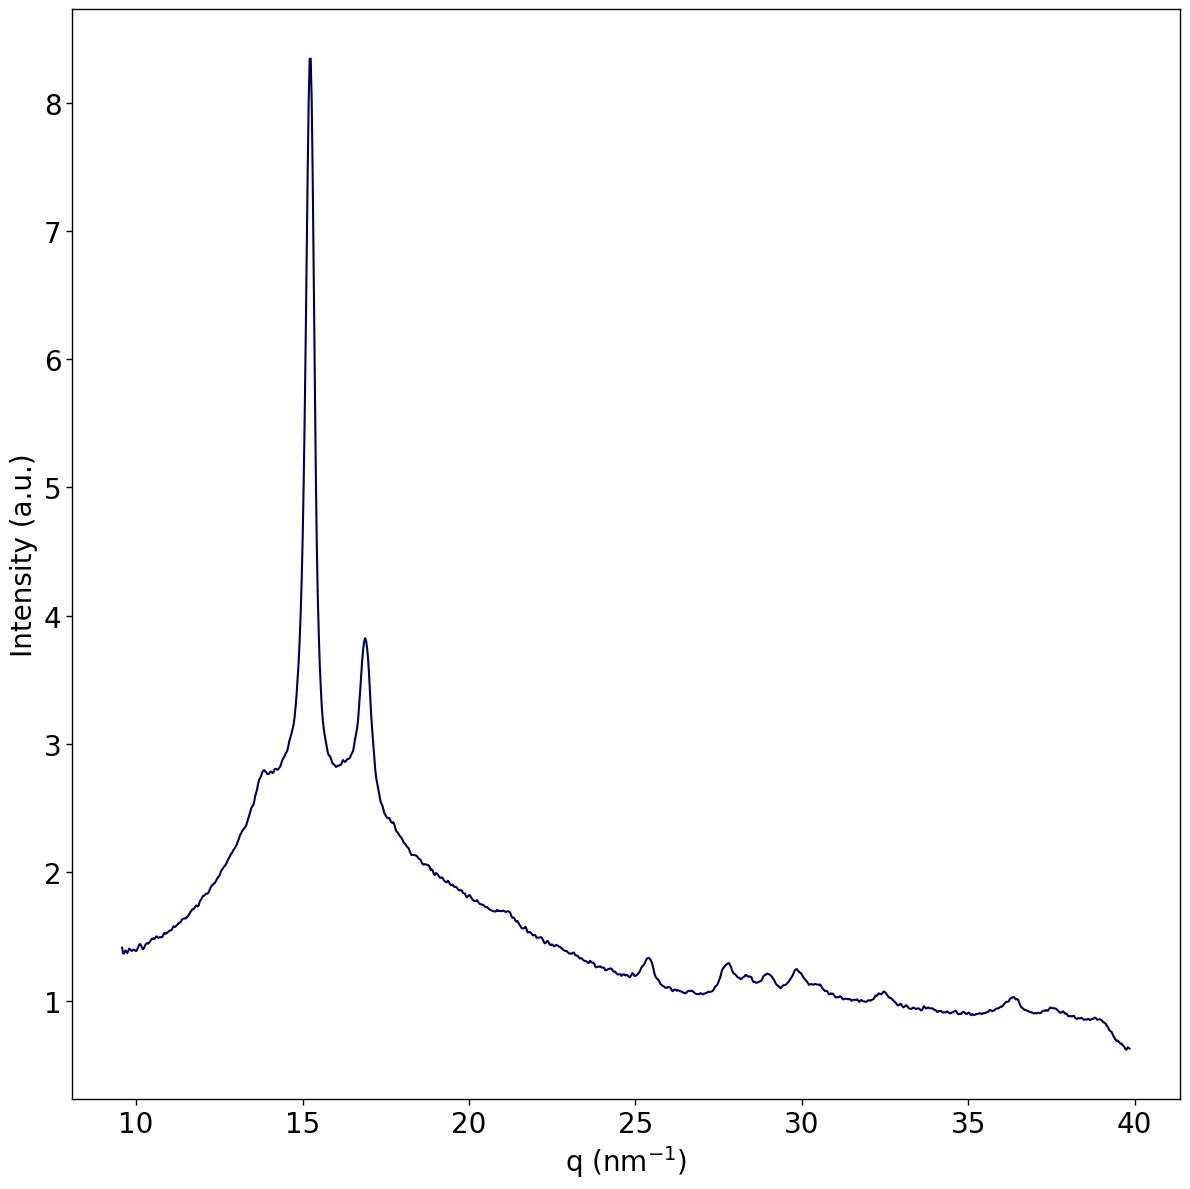

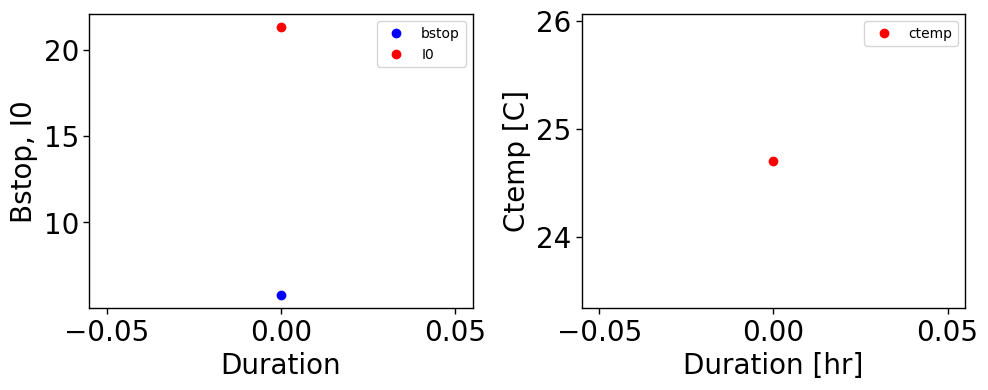

In [15]:
#raw_dir_meth = r'X:\bl1-5\Anjani\Autoxidation\Jan2025\RT\RTSoak'
# Run 23c
#common_keyword = ""  # folder name
#keyword = "*Empty*" # file name

#keywords, SAXS_folder_name, WAXS_folder_name,data_folder = get_keywords(raw_dir_meth, common_keyword, keyword)

#process_SAXS_data(SAXS_folder_name, keywords, data_folder, ai)
#process_WAXS_data(WAXS_folder_name, keywords, data_folder, ai_w)


raw_dir = os.path.join(base_dir, '')

#raw_dir_meth = r'X:\bl1-5\Anjani\RedesignedPlastic\Jan2025\Fibers3'


common_keyword = ""  # folder name
keywords = ['*Run5_*RampT*']# file name
# loop over the keywords
for keyword in keywords:
     keywords, SAXS_folder_name, WAXS_folder_name,data_folder = get_keywords(raw_dir, common_keyword, keyword)
     
     process_SAXS_data(SAXS_folder_name, keywords, data_folder, ai, saxs_mask, i0_offset=0, bstop_offset=0, i0_air=0, bstop_air=0)
     process_WAXS_data(WAXS_folder_name, keywords, data_folder, ai_w, waxs_mask, i0_offset=0, bstop_offset=0, i0_air=0, bstop_air=0)


In [16]:
# keywords, SAXS_folder_name, WAXS_folder_name,data_folder = get_keywords(raw_dir, common_keyword, keyword)